In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_df = engineer_features(sorted_dyads_df)

df_train = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
# df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=False)
df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_27960/3038958328.py:9: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


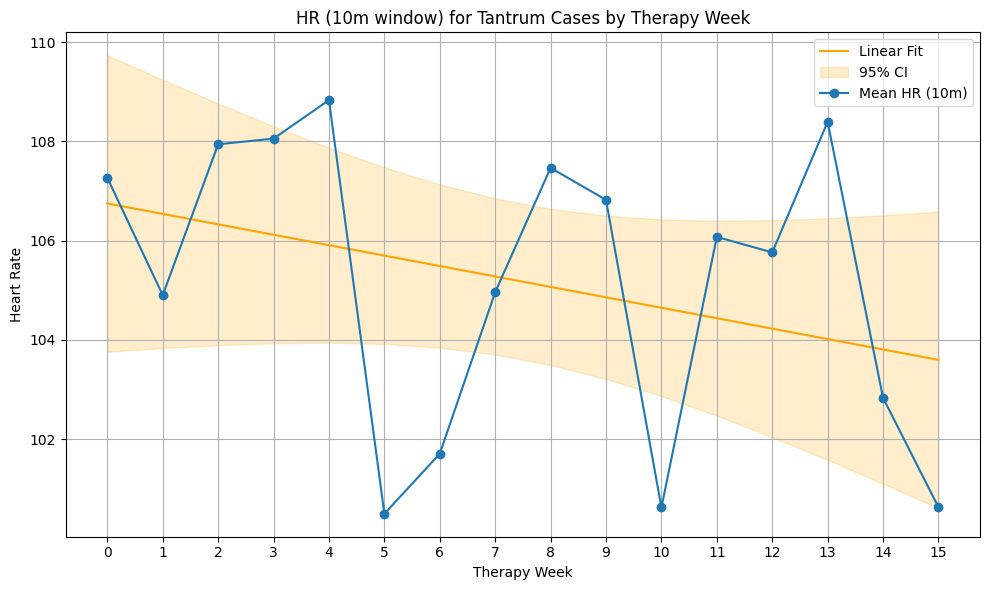

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

weeks = (0, 15)
window = "60m"
feature = "hr_moving_avg_10m"


# Filter for cases with tantrum within 15m and therapy_week in 0-10
df_all = pd.concat([df_train, df_test])
weeks_range = range(weeks[0], weeks[1] + 1)
mask = (df_all["tantrum_within_60m"]) & ((df_all["therapy_week"]).between(*weeks))
df_cases = df_all[mask]


means = []
mins = []
maxs = []

for week in weeks_range:
    week_data = df_cases[df_cases["therapy_week"] == week]
    means.append(week_data[feature].mean())

# Prepare data for regression
x = np.array(list(weeks_range))
y = np.array(means)

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_pred = intercept + slope * x

# Compute 95% CI for regression line
n = len(x)
t_val = stats.t.ppf(0.975, n - 2)
y_fit = intercept + slope * x
residuals = y - y_fit
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
conf = (
    t_val
    * s_err
    * np.sqrt(1 / n + (x - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2))
)


plt.figure(figsize=(10, 6))

# Plot regression line and CI
plt.plot(x, y_pred, color="orange", label="Linear Fit")
plt.fill_between(
    x, y_pred - conf, y_pred + conf, color="orange", alpha=0.2, label="95% CI"
)
plt.plot(weeks_range, means, marker="o", label="Mean HR (10m)")
# plt.axhline(105, color="red", linestyle="--")
# plt.axhline(129, color="red", linestyle="--")
plt.legend()
plt.xlabel("Therapy Week")
plt.ylabel("Heart Rate")
plt.title("HR (10m window) for Tantrum Cases by Therapy Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(weeks_range)
plt.show()

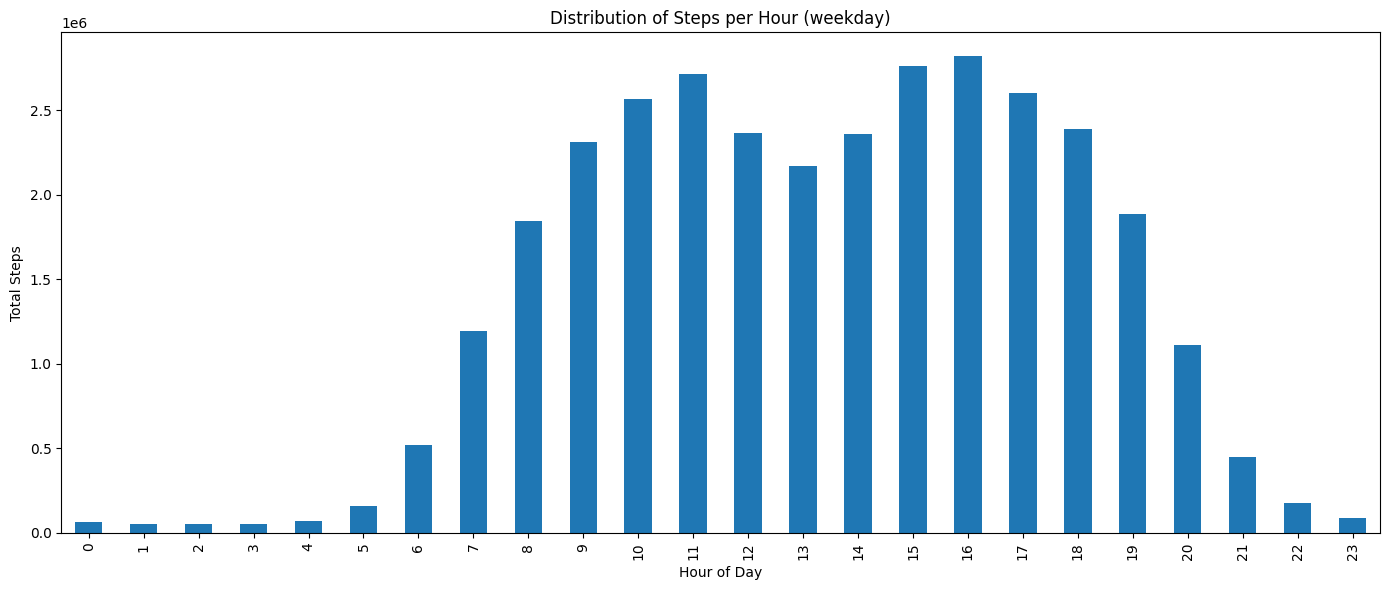

In [15]:
import matplotlib.pyplot as plt

# Group by date and sum steps per day
steps_per_hour = df_all.groupby(df_all["ActivityDateTime"].dt.hour)[
    "steps_0_to_15m"
].sum()

plt.figure(figsize=(14, 6))
steps_per_hour.plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Total Steps")
plt.title("Distribution of Steps per Hour (weekday)")
plt.tight_layout()
plt.show()